### Практическая работа к уроку № 4

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

#### 1. скачать набор данных маркетинговых каsklearn.model_selectionps://www.kaggle.com/davinwijaya/customer-retention

In [2]:
df = pd.read_csv('HW_data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


#### 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
df.rename(columns={"conversion": "target",
                   "offer": "treatment"},
         inplace=True)
df["treatment"].replace({"Buy One Get One": 1,
                         "Discount": 1,
                         "No Offer": 0},
                        inplace=True)

#### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [4]:
cat_features = [column for column in df.columns if df[column].dtype == 'object']
cat_features

['zip_code', 'channel']

In [5]:
features = list(df.columns)
features.remove("treatment"); features.remove("target")
features

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'zip_code',
 'is_referral',
 'channel']

/home/mayo889/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


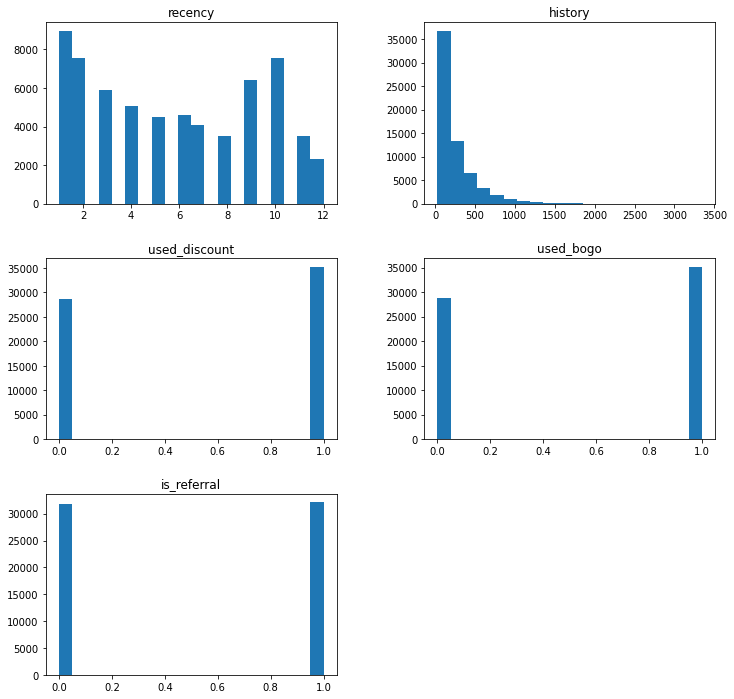

In [6]:
df[features].hist(figsize=(12, 12), bins=20, grid=False);

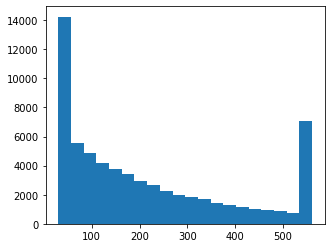

In [7]:
# Уберем слишком длинный хвост признака history
condition = df['history'] > df['history'].quantile(.9)
df.loc[condition, 'history'] = df['history'].quantile(.9)
df["history"].hist(figsize=(5, 4), bins=20, grid=False);

#### 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [8]:
train_idx, val_idx = train_test_split(df.index, test_size=0.3, random_state=123)

X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, 'target']
treat_train = df.loc[train_idx, 'treatment']

X_val = df.loc[val_idx, features]
y_val = df.loc[val_idx, 'target']
treat_val =  df.loc[val_idx, 'treatment']

#### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

#### 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [9]:
models_result = {
    "SoloModel": [],
    "ClassTransformation": [],
    "TwoModels": []
}

Одна модель с признаком коммуникации (S learner)

In [10]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

for metric in [0.1, 0.2]:
    sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm,
                           treatment=treat_val, strategy='by_group', k=metric)
    models_result["SoloModel"].append(sm_score)

Модель с трансформацией таргета

In [11]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

for metric in [0.1, 0.2]:
    ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct,
                           treatment=treat_val, strategy='by_group', k=metric)
    models_result["ClassTransformation"].append(ct_score)

Две независимые модели

In [12]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

for metric in [0.1, 0.2]:
    tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm,
                           treatment=treat_val, strategy='by_group', k=metric)
    models_result["TwoModels"].append(tm_score)

Сводка результатов

In [13]:
result_df = pd.DataFrame.from_dict(models_result, orient="index",
                      columns=["uplift@10%", "uplift@20%"]).sort_values(by=["uplift@10%"],
                                                                        ascending=False)
result_df

,uplift@10%,uplift@20%
ClassTransformation,0.124445,0.098925
TwoModels,0.108004,0.077815
SoloModel,0.092382,0.076256
